### Introduction to PyTorch and Neural Networks
#### Charles Stewart
#### Last revision: March 24, 2021

This is a brief tutorial introduction to PyTorch using a specific example of building a neural network that learns to classify points as inside or outside a hyper sphere
of a given radius.

We'll start with the problem itself, working purely in NumPy in order to clarify
what we are trying to do.  After this, we'll introduce the basic notation of PyTorch, and proceed to two different neural network solutions.

Please feel free to search for and examine other tutorials. I wrote this one and am teaching from it, but others might be equally or even more helpful!



## Google Colaboratory

The document you are working with right now is written as a Jupyter notebook.  We will see how to use it as a Google colaboratory notebook, giving us access to GPU computations.  Several things have to happen for you to get started with this.

1.   Put the notebook on Google Drive
2.   Link the app:  On Google Drive click New -> More -> Connect More Apps and then choose Google Colaboratory.  You can make this app the default for .ipynb files
3.   Open the notebook you'd like to work with
4.   Make sure pytorch is installed by typing

         !pip install torch

         !pip install torchvision

      in a notebook code cell.  The ! indicates that what follows is a shell command.  

5.   You can switch back and forth between running on the Google cloud on a CPU (the default) or a GPU.  I recommend running on the CPU until your networks are debugged because GPU execution runs you out of free compute credits faster.  To make the change, on the top menu click **Runtime -> Change runtime type**, and then make the appropriate selection.




## Now for the problem

Generated points in array of dimension (400, 2)
Binary labels are in a second array of dimension (400, 2)


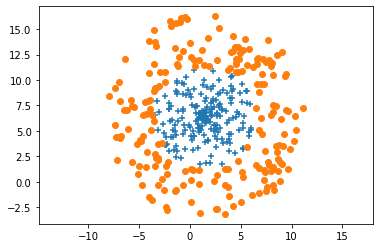

In [1]:
# -*- coding: utf-8 -*-
import numpy as np

def gen_from_sphere(n, center, r_min, r_max):
    '''
    Generate n points in random directions from a center that are at least
    r_min away and at most r_max away.  If r_min is 0 then the points are
    within a hyper sphere of radius r_max.  Otherwise, the points are within a
    spherical shell whose minimum radius is r_min and whose maximum radius
    is r_max.  Note that the points generated in this simple way are not
    uniformly distributed in Euclidean space, but that is not a major concern
    here.
    
    The dimensionality of the space is inferred from the dimension of the center
    point.  
    
    Return an array where each row is a data point. I.e. the array dimensions are (n, dim)
    '''
    dim = center.size
    points = np.broadcast_to(center.reshape(1, dim), (n, dim)) 
    directions = 2 * np.random.random((n, dim)) - 1
    directions /= np.linalg.norm(directions, axis=1).reshape((n, 1))
    offsets = np.random.random(n) * (r_max - r_min) + r_min
    points = points + directions * offsets.reshape((n, 1))
    return points


def gen_points_nested_spheres(n, center, r_min, r_max, debug=False):
    '''
    Generate n data points in hypersphere, half of which - the "inliers" --
    are within r_min of the center and half of which -- the "outliers" -- are
    between r_min and r_max.  Returned are the points in an n X d array
    (dim is the dimension of the center point) and a n X 2 binary array
    labeling whether the points are inliers (1,0) or outliers (0,1).
    
    If the debug flag is on, the array shape of the points and the labels
    are output.  In addition, if the dimension is 2 then a plot is generated.
    '''
    num_inliers = n//2
    num_outliers = n - num_inliers
    inlier_X = gen_from_sphere(num_inliers, center, 0, r_min)
    inlier_Y = np.broadcast_to(np.array([1., 0.]), (num_inliers, 2))
    outlier_X = gen_from_sphere(num_outliers, center, r_min, r_max)
    outlier_Y = np.broadcast_to(np.array([0., 1.]), (num_outliers, 2))
    X = np.concatenate((inlier_X, outlier_X), axis=0)
    Y = np.concatenate((inlier_Y, outlier_Y), axis=0)
    
    if debug:
        print('Generated points in array of dimension', X.shape)
        print('Binary labels are in a second array of dimension', Y.shape)
        
        if center.size == 2:
            from matplotlib import pyplot as plt
            plt.scatter(inlier_X[:,0], inlier_X[:,1], marker='+' )
            plt.scatter(outlier_X[:,0], outlier_X[:,1], marker='o' )
            plt.axis('equal')
            plt.show()

    return X,Y

# Generate an example in 2d, just to see the point distribution
# The "real" data will be in higher dimensions. 
num_points = 400
center = np.array([1.5, 6.4])
r_min, r_max = 5, 10
X,Y = gen_points_nested_spheres(num_points, center, r_min, r_max, debug=True)


### PyTorch

Now for PyTorch.  The starting point is http://pytorch.org/tutorials/ for tutorials and http://pytorch.org/docs/master/ for extensive documentation.  On the tutorials site, I found both the "60 Minute Blitz" and "Learning PyTorch with Examples" to be useful, but preferred the latter.  It starts with a simple neural network implemented in NumPy, then converts this to use of PyTorch Tensors.  Next it introduces Variables and their most important property, automatic gradient calculation ("autograd").  At that point it has two subsections, one on defining new autograd functions and the second comparing to TensorFlow Static Graphs.  Neither of these is terribly important on first reading.  Instead, I'd suggest skipping ahead to the nn module.  I suggest going back to the 60 Minute Blitz for examples of convolutional layers.

We'll start here with a brief discussion of Tensors and Variables and then jump right into Neural Networks.

In [2]:
import torch
from torch.autograd import Variable

# The first important property of torch is the notion of a Tensor.  This is essentially
# the same as a NumPy array, but it has CUDA / GPU capabilities when a GPU is available.
# We can easily convert back and forth between Tensors and arrays without deep copying

# The following creates a 2d tensor with 6 rows and 3 columns, filled in with random
# values from a normal distribution of mean 0 and variance 1.
w = torch.randn(6, 3)
print('First tensor: w')
print(w)

First tensor: w
tensor([[-0.6433,  1.2378, -0.7605],
        [-0.2468, -0.5570, -0.3981],
        [-0.8080, -0.2385, -0.0565],
        [-0.3447,  0.2736,  1.8325],
        [ 1.3541,  0.2230, -0.6426],
        [-1.2298,  0.0408, -1.2793]])


In [3]:
# Like NumPy arrays, tensors can be sliced and this occurs without deep copying
x = w[2:4, 0:2]
print('Sliced verson of w is x:')
print(x)
x[0,1] = 20
print('We changed x[0,1] to', x[0,1], 'and now w[2,1] is also', w[2,1])
print("w is now\n", w)

Sliced verson of w is x:
tensor([[-0.8080, -0.2385],
        [-0.3447,  0.2736]])
We changed x[0,1] to tensor(20.) and now w[2,1] is also tensor(20.)
w is now
 tensor([[-0.6433,  1.2378, -0.7605],
        [-0.2468, -0.5570, -0.3981],
        [-0.8080, 20.0000, -0.0565],
        [-0.3447,  0.2736,  1.8325],
        [ 1.3541,  0.2230, -0.6426],
        [-1.2298,  0.0408, -1.2793]])


In [4]:
#  Create a row vector and then do component-wise multiplication
u = torch.randn(3)
print('u', u)
print('3-component vector as a tensor:', u)
print('Component-wise multiplication, with broadcasting')
print(w*u)

u tensor([0.2441, 0.9981, 0.7786])
3-component vector as a tensor: tensor([0.2441, 0.9981, 0.7786])
Component-wise multiplication, with broadcasting
tensor([[-0.1570,  1.2354, -0.5922],
        [-0.0602, -0.5559, -0.3100],
        [-0.1972, 19.9622, -0.0440],
        [-0.0841,  0.2731,  1.4268],
        [ 0.3305,  0.2226, -0.5004],
        [-0.3002,  0.0407, -0.9961]])


In [5]:
#  Now create a 3x1 tensor--- essentially a column vector --- and do
#  matrix multiplication
u = torch.randn(3, 1)
print('u', u)
print(torch.mm(w,u))

u tensor([[-0.8142],
        [ 0.5081],
        [-0.6996]])
tensor([[ 1.6848],
        [ 0.1965],
        [10.8591],
        [-0.8624],
        [-0.5396],
        [ 1.9171]])


In [6]:
#  Many of the methods you'd expect for NumPy arrays exist for PyTorch tensors.  See
#  extensive documentation at http://pytorch.org/docs/master/torch.html#tensors

# We can go back and forth between NumPy arrays and PyTorch tensors
# through shallow copies
a = u.numpy()
print('a is the numpy version of u:\n', a)
b = torch.from_numpy(a)
c = torch.Tensor(b)
print('b and c are back to pytorch:', b)
a[0,0] = 5
print('We changed a[0,0] and this changes b and c as well:')
print('b[0,0] =', b[0,0], 'and c[0,0] =', c[0,0])

a is the numpy version of u:
 [[-0.81423676]
 [ 0.508085  ]
 [-0.6996436 ]]
b and c are back to pytorch: tensor([[-0.8142],
        [ 0.5081],
        [-0.6996]])
We changed a[0,0] and this changes b and c as well:
b[0,0] = tensor(5.) and c[0,0] = tensor(5.)


In [7]:
# So why create a separate class for tensors when they seem to have
# the same attributes as as NumPy arrays?  There are two answers.

# First, tensors are designed to work with CUDA when a GPU is available,
# but this is transparent to the rest of the code.  Here is one way to 
# handle this, which is enough for now, but there are others in the PyTorch
# library.
if torch.cuda.is_available():
    print("Converting w and b to GPU")
    w = w.to("cuda")
    b = b.to("cuda")

c = torch.mm(w,b)
print('Tensor c is\n', c)  # Proceeds whether on CPU or GPU

Tensor c is
 tensor([[-2.0557],
        [-1.2384],
        [ 6.1613],
        [-2.8664],
        [ 7.3336],
        [-5.2331]])


### PyTorch Variables
The second reason for PyTorch tensors is that they are designed to work with our second
major PyTorch construct:  Variables.  A Variable has three major attributes:
1. data --- A PyTorch tensor.   
2. grad --- The gradient tensor of the variable with respect to the final cost function it is used in
3. creator - The link to the function the Variable is created from.  More on this below

In [8]:
print('Reminding ourselves:  w=\n', w)


Reminding ourselves:  w=
 tensor([[-0.6433,  1.2378, -0.7605],
        [-0.2468, -0.5570, -0.3981],
        [-0.8080, 20.0000, -0.0565],
        [-0.3447,  0.2736,  1.8325],
        [ 1.3541,  0.2230, -0.6426],
        [-1.2298,  0.0408, -1.2793]])


In [9]:
# Now create a variable from w, telling the constructor that we want
# to be able to compute gradients on this variable.
wv = Variable(w, requires_grad=True)
print("wv=\n", wv)
print('wv.data =\n', wv.data)
print('Slicing works on variables:\n', wv[2:4,1:3])

wv=
 tensor([[-0.6433,  1.2378, -0.7605],
        [-0.2468, -0.5570, -0.3981],
        [-0.8080, 20.0000, -0.0565],
        [-0.3447,  0.2736,  1.8325],
        [ 1.3541,  0.2230, -0.6426],
        [-1.2298,  0.0408, -1.2793]], requires_grad=True)
wv.data =
 tensor([[-0.6433,  1.2378, -0.7605],
        [-0.2468, -0.5570, -0.3981],
        [-0.8080, 20.0000, -0.0565],
        [-0.3447,  0.2736,  1.8325],
        [ 1.3541,  0.2230, -0.6426],
        [-1.2298,  0.0408, -1.2793]])
Slicing works on variables:
 tensor([[20.0000, -0.0565],
        [ 0.2736,  1.8325]], grad_fn=<SliceBackward>)


In [10]:
#  Next create a simple cost function
cost = torch.mean(wv * wv)  # Cost is the square magnitude of the elements of the matrix
print('cost is', cost)

cost is tensor(22.9283, grad_fn=<MeanBackward0>)


#### Now comes the gradient!
By calling the method *backward*, we backpropagate the gradient through the computation used to create the cost function value.  In this simple case, we are computing the gradient with respect to the terms of our our small $m \times n$ ($ 6 \times 3$) 2d tensor.  The result should be another 2d tensor whose values are $\frac{2}{m n} w[i,j]$. When we ask for the values of the gradient we get exactly what we predicted.  For example, the 2,2 entry in the gradient, corresponding to the value 20 in wv, is $2/18\times 20$ as the following shows:

In [11]:
cost.backward()
print('wv.grad=\n', wv.grad)

wv.grad=
 tensor([[-0.0715,  0.1375, -0.0845],
        [-0.0274, -0.0619, -0.0442],
        [-0.0898,  2.2222, -0.0063],
        [-0.0383,  0.0304,  0.2036],
        [ 0.1505,  0.0248, -0.0714],
        [-0.1366,  0.0045, -0.1421]])


One note about the calculation of the gradient through the call to the backward method is that by default PyTorch releases intermediate buffers for the gradient computation at the end of the backward calculation through the graph.  If you run the previous step a second time - without going further up and redefining the cost function - you will get a run-time error. We can demonstrate this by just rerunning the cell.

###  Creator / grad_fn

In order to briefly discuss the creator function, we take this further in the following example by combining several variables, similar to the computation in a fully connected layer of a neural network.  This combination can be thought of as a simple graph where the root is the cost function, each node in the middle is the result of an intermediate function, and our leaves are the initial variables we are interested in. The nodes have grad_fn that point back to the previous nodes (or leaves) combined to create them.  Leaves have no grad_fn.

The print statements from the following only show these grad_fn values, but if you wish you can add print statements to calculate the gradients.


In [19]:
av = Variable(torch.randn(3, 1), requires_grad=True)
bv = Variable(torch.randn(6, 1), requires_grad=True)
if torch.cuda.is_available():
    av = av.to("cuda")
    bv = bv.to("cuda") 
mult = torch.mm(wv, av) + bv
cost = torch.mean(mult)
cost.backward()
print('cost.grad_fn:', cost.grad_fn)
print('mult.grad_fn:', mult.grad_fn)
print('av.grad_fn:', av.grad_fn)
print('bv.grad_fn:', bv.grad_fn)
print('wv.grad_fn:', wv.grad_fn)
print('av.grad:\n', av.grad)
print('bv.grad:\n', bv.grad)
print('wv.grad:\n', wv.grad)

cost.grad_fn: <MeanBackward0 object at 0x7f4e88a16610>
mult.grad_fn: <AddBackward0 object at 0x7f4e88a16190>
av.grad_fn: None
bv.grad_fn: None
wv.grad_fn: None
av.grad:
 tensor([[-0.3197],
        [ 3.5364],
        [-0.2174]])
bv.grad:
 tensor([[0.1667],
        [0.1667],
        [0.1667],
        [0.1667],
        [0.1667],
        [0.1667]])
wv.grad:
 tensor([[ 0.2570,  0.3056, -0.0590],
        [ 0.3011,  0.1062, -0.0188],
        [ 0.2387,  2.3903,  0.0192],
        [ 0.2902,  0.1985,  0.2291],
        [ 0.4790,  0.1928, -0.0459],
        [ 0.1919,  0.1726, -0.1167]])


### Neural Networks in PyTorch
Using Variables and the build up of functions between them, we can create neural network by hand.  Doing so is a good exercise in understanding the basics of PyTorch and if you are going to do significant work in neural networks I recommend that you do so.  For our purposes, however, we are going to switch gears to the higher-level capabilities in PyTorch for defining an using neural networks from standard components.

Before getting started, we return to our hypersphere classification problem, and generate the data we will actually use to train, validate and test our neural network.

In [13]:
#  The points, the center location and the dimensions of the 
#  internal hypersphere and the external disk.
point_dim = 4
center = 10*np.random.randn(point_dim)
r_min, r_max = 4, 8

def generate_and_convert(n, center, r_min, r_max, debug=True, name=''):
    '''
    Generate the data for the interior and exterior points and convert
    to PyTorch variables.
    '''
    X, Y = gen_points_nested_spheres( n, center, r_min, r_max, debug)
    X, Y = Variable(torch.Tensor(X)), Variable(torch.Tensor(Y))
    if debug:
        print('generate_and_convert for', name, ' X size', X.size(), ' Y size', Y.size())
    if torch.cuda.is_available():
        X = X.to("cuda")
        Y = Y.to("cuda")
    return X, Y

n_train, n_valid, n_test = 1000, 128, 128
X_train, Y_train = generate_and_convert(n_train, center, r_min, r_max, debug=True, name='Train')
X_valid, Y_valid = generate_and_convert(n_valid, center, r_min, r_max, debug=True, name='Valid')
X_test, Y_test = generate_and_convert(n_test, center, r_min, r_max, debug=True, name='Valid')



Generated points in array of dimension (1000, 4)
Binary labels are in a second array of dimension (1000, 2)
generate_and_convert for Train  X size torch.Size([1000, 4])  Y size torch.Size([1000, 2])
Generated points in array of dimension (128, 4)
Binary labels are in a second array of dimension (128, 2)
generate_and_convert for Valid  X size torch.Size([128, 4])  Y size torch.Size([128, 2])
Generated points in array of dimension (128, 4)
Binary labels are in a second array of dimension (128, 2)
generate_and_convert for Valid  X size torch.Size([128, 4])  Y size torch.Size([128, 2])


### Defining a simple fully connected network

The cell below shows the definition of a neural network with two hidden layers of 15 nodes each.
It is defined as a subclass of the nn.Module class, so the first step in the initializer is to call the initializer for the base class.
The initializer for our new class creates the layers --- each fully-connected --- but does not hook them together.  This is done in the forward function.
You will also notice that there is no definition of the backward function, even though it is used.
This function is created in the base class based on the result of the forward function.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

N0 = point_dim
N1 = 15
N2 = 15
Nout = 2  

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Create three fully connected layers, two of which are hidden and the third is
        # the output layer.  In each case, the first argument to Linear is the number
        # of input values from the previous layer, and the second argument is the number
        # of nodes in this layer.  The call to the Linear initializer creates a PyTorch
        # functional that in turn adds a weight matrix and a bias vector to the list of
        # (learnable) parameters stored with each Net object.  These weight matrices
        # and bias vectors are implicitly initialized using a uniform random distribution,
        # in the range [-1/sqrt(k), 1/sqrt(k)] where k is the number of units at the
        # previous layer.
        self.fc1 = nn.Linear(N0, N1, bias=True)
        self.fc2 = nn.Linear(N1, N2, bias=True)
        self.fc3 = nn.Linear(N2, Nout, bias=True)

    def forward(self, x):
        #  The forward method takes an input Variable and creates a chain of Variables
        #  from the layers of the network defined in the initializer. The F.relu is
        #  a functional implementing the Rectified Linear activation function.
        #  Notice that the output layer does not include the activation function.
        #  As we will see, that is combined into the criterion for the loss function.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#  Create an instance of this network.
net = Net()
if torch.cuda.is_available():
    net = net.to("cuda")

#  Define the Mean Squared error loss function as the criterion for this network's training
criterion = nn.MSELoss()

#  Print a summary of the network.  Notice that this only shows the layers
print(net)

#  Print a list of the parameter sizes
params = list(net.parameters())
print(params[0].size()) # The parameter holding the layer 1 weight matrix
print(params[1].size()) # ... the layer 1 bias vector
print(params[2].size()) # ... the layer 2 weight matrix
print(params[3].size()) # ... the layer 2 bias vector
print(params[4].size()) # ... the layer 3 weight vector
print(params[5].size()) # ... the layer 3 bias vector

print(params[0])
print(params[1])

Net(
  (fc1): Linear(in_features=4, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=15, bias=True)
  (fc3): Linear(in_features=15, out_features=2, bias=True)
)
torch.Size([15, 4])
torch.Size([15])
torch.Size([15, 15])
torch.Size([15])
torch.Size([2, 15])
torch.Size([2])
Parameter containing:
tensor([[ 0.3239,  0.1502,  0.1813,  0.1629],
        [ 0.2027, -0.2124,  0.1469, -0.0763],
        [-0.3688,  0.1415, -0.2200, -0.3335],
        [-0.0412,  0.4222, -0.0024,  0.3027],
        [-0.3643,  0.0585,  0.3595,  0.2901],
        [ 0.0778, -0.0220,  0.0201, -0.4584],
        [ 0.2003,  0.2994, -0.1394,  0.4877],
        [-0.2774, -0.1958,  0.3250,  0.0018],
        [-0.1858, -0.0084,  0.4248,  0.1034],
        [-0.2810,  0.3100,  0.2467, -0.4098],
        [-0.3380,  0.2827,  0.4946,  0.3593],
        [ 0.3303,  0.0813,  0.0772, -0.0667],
        [ 0.3712, -0.1940, -0.0283,  0.3582],
        [-0.4655, -0.0830, -0.0457, -0.1997],
        [-0.1843,  0.0436,  0.0383, -0

####  Training the network

Now we can write our own training function using a form of stochastic gradient descent. 

In [15]:
#  Set parameters to control the process
epochs = 1000
batch_size = 16
n_batches = int(np.ceil(n_train / batch_size))
learning_rate = 1e-4

#  Compute an initial loss using all of the validation data.
#
#  A couple of notes are important here:
#  (1) X_valid contains all of the validation input, with each validation
#      data instance being a row of X_valid
#  (2) Therefore, pred_Y_valid is a Variable containing the output layer
#      activations for each of the validation inputs.
#  (3) This is accomplished through the function call net(X_valid), which in
#      turn calls the forward method under the hood to figure out the flow of
#      the data and activations in the network.
print(X_valid)
pred_Y_valid = net(X_valid)
valid_loss = criterion(pred_Y_valid, Y_valid)
print("Initial loss: %.5f" % valid_loss.item())

for ep in range(epochs):
    #  Create a random permutation of the indices of the row vectors.
    indices = torch.randperm(n_train)
    
    #  Run through each mini-batch
    for b in range(n_batches):
        #  Use slicing (of the pytorch Variable) to extract the
        #  indices and then the data instances for the next mini-batch
        batch_indices = indices[b*batch_size: (b+1)*batch_size]
        batch_X = X_train[batch_indices]
        batch_Y = Y_train[batch_indices]
        
        #  Run the network on each data instance in the minibatch
        #  and then compute the object function value
        pred_Y = net(batch_X)
        loss = criterion(pred_Y, batch_Y)
        
        #  Back-propagate the gradient through the network using the
        #  implicitly defined backward function, but zero out the
        #  gradient first.
        net.zero_grad()
        loss.backward()

        #  Complete the mini-batch by actually updating the parameters.
        for param in net.parameters():
            param.data -= learning_rate * param.grad.data
            
    #  Print validation loss every 10 epochs
    if ep != 0 and ep%10 == 0:
        pred_Y_valid = net(X_valid)
        valid_loss = criterion(pred_Y_valid, Y_valid)
        print("Epoch %d loss: %.5f" %(ep, valid_loss.item()))

#  Compute and print the final training and test loss
#  function values
pred_Y_train = net(X_train)
loss = criterion(pred_Y_train, Y_train)
print('Final training loss is %.5f' %loss.item())

pred_Y_test = net(X_test)
test_loss = criterion(pred_Y_test, Y_test)
print("Final test loss: %.5f" % test_loss.item())


tensor([[ 4.2145e+00, -9.3042e+00,  3.3114e-01,  1.6476e+00],
        [ 3.9051e+00, -8.4209e+00,  1.1095e+00, -2.8127e-01],
        [ 1.1302e+00, -8.7924e+00, -1.7168e-01,  1.0972e+00],
        [ 3.5849e+00, -8.3016e+00,  1.4794e+00, -3.0387e-01],
        [ 3.5889e+00, -7.4530e+00,  2.0948e+00, -4.4369e-01],
        [ 2.9404e+00, -7.1914e+00,  6.4797e-01,  7.0034e-02],
        [ 3.1755e+00, -8.6474e+00,  1.1205e+00, -1.8142e-01],
        [ 3.4502e+00, -8.3558e+00,  1.4669e+00, -4.9206e-01],
        [ 4.0135e+00, -9.3808e+00,  1.5809e+00, -1.2933e+00],
        [ 4.0477e+00, -9.1563e+00,  9.7955e-03,  8.3361e-01],
        [ 1.6878e+00, -1.1169e+01, -1.9228e-01, -1.4984e-01],
        [ 4.5837e+00, -9.3113e+00,  2.5631e-01,  1.5913e-01],
        [ 2.1086e+00, -9.6220e+00,  4.3191e-01, -2.2938e+00],
        [ 3.9068e+00, -8.0055e+00,  1.7102e+00, -3.4386e-01],
        [ 3.6738e+00, -7.7041e+00,  2.2408e+00, -1.3280e+00],
        [ 3.6078e+00, -8.3329e+00,  1.5240e+00, -2.9019e-01],
        

### Classification Success Rate

The loss function value does not indicate the actual success rate.  In fact the MSE loss can in theory be arbitrarily bad and we could still have perfect classification.  By increasing the size of the training data and the number of epochs we can obtain better and better classification rates.

In [16]:
def success_rate(pred_Y, Y):
    '''
    Calculate and return the success rate from the predicted output Y and the
    expected output.  There are several issues to deal with.  First, the pred_Y
    is non-binary, so the classification decision requires finding which column
    index in each row of the prediction has the maximum value.  This is achieved
    by using the torch.max() method, which returns both the maximum value and the
    index of the maximum value; we want the latter.  We do this along the column,
    which we indicate with the parameter 1.  Second, the once we have a 1-d vector
    giving the index of the maximum for each of the predicted and target, we just
    need to compare and count to get the number that are different.  We could do
    using the Variable objects themselves, but it is easier syntactically to do this
    using the .data Tensors for obscure PyTorch reasons.
    '''
    _,pred_Y_index = torch.max(pred_Y, 1)
    _,Y_index = torch.max(Y,1)
    num_equal = torch.sum(pred_Y_index.data == Y_index.data).item()
    num_different = torch.sum(pred_Y_index.data != Y_index.data).item()
    rate = num_equal / float(num_equal + num_different)
    return rate 

print('Training success rate:', success_rate(pred_Y_train, Y_train))
print('Test success rate:', success_rate(pred_Y_test, Y_test))

Training success rate: 0.838
Test success rate: 0.8203125


### Using Cross Entropy, SoftMax and SGD

As a final step in our initial learning of PyTorch, we'll examine use of the Cross-entropy loss function along with the softmax.  Then we'll examine use of built-in optimizers, in particular stochastic gradient descent (SGD).  Normally we think of SGD as having mini-batches and permutations associated with it, but that must be done explicitly here.  PyTorch does provide tools to help us, but this tutorial does not dig into them.

Unfortunately, SGD requires the target outputs to be categorical indices as rather than binary vectors. For example, the instead of [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent the digit 3, we just use the value 3. In addition, these must be tensors of longs rather than tensors of doubles.   We could go back and change the code at the very beginning to make both of these corrections, but instead we use properties of PyTorch to make the changes here.

In [17]:
def convert_to_categories(Y):
    _, categories = torch.max(Y.data, 1)
    categories = torch.Tensor.long(categories)
    return Variable(categories)

Y_test_c = convert_to_categories(Y_test)
Y_train_c = convert_to_categories(Y_train)
Y_valid_c = convert_to_categories(Y_valid)


In [18]:
net = Net()
if torch.cuda.is_available():
    net = net.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-4)

pred_Y_valid = net(X_valid)
valid_loss = criterion(pred_Y_valid, Y_valid_c)
print('Initial validation loss: %.5f' % valid_loss.item())

num_epochs = 3000
for ep in range(num_epochs):
    #  Create a random permutation of the indices of the row vectors.
    indices = torch.randperm(n_train)
    
    #  Run through each mini-batch
    for b in range(n_batches):
        #  Use slicing (of the pytorch Variable) to extract the
        #  indices and then the data instances for the next mini-batch
        batch_indices = indices[b*batch_size:(b+1)*batch_size]
        batch_X = X_train[batch_indices]
        batch_Y = Y_train_c[batch_indices]
        
        #  Run the network on each data instance in the minibatch
        #  and then compute the object function value
        pred_Y = net(batch_X)
        loss = criterion(pred_Y, batch_Y)
        
        #  Back-propagate the gradient through the network using the
        #  implicitly defined backward function, but zero out the
        #  gradient first.  The step is made here by the optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    pred_Y = net(X_train)
    loss = criterion(pred_Y, Y_train_c)
    if ep !=0 and ep%10==0:
        pred_Y_valid = net(X_valid)
        valid_loss = criterion(pred_Y_valid, Y_valid_c)
        print("Epoch %d loss: %.5f" %(ep, valid_loss.item()))

pred_Y_train = net(X_train)
pred_Y_test = net(X_test)
print('Training success rate:', success_rate(pred_Y_train, Y_train))
print('Test success rate:', success_rate(pred_Y_test, Y_test))

Initial validation loss: 0.81114
Epoch 10 loss: 0.70448
Epoch 20 loss: 0.67489
Epoch 30 loss: 0.66036
Epoch 40 loss: 0.65006
Epoch 50 loss: 0.64136
Epoch 60 loss: 0.63371
Epoch 70 loss: 0.62660
Epoch 80 loss: 0.62016
Epoch 90 loss: 0.61430
Epoch 100 loss: 0.60887
Epoch 110 loss: 0.60409
Epoch 120 loss: 0.59948
Epoch 130 loss: 0.59520
Epoch 140 loss: 0.59094
Epoch 150 loss: 0.58698
Epoch 160 loss: 0.58327
Epoch 170 loss: 0.57974
Epoch 180 loss: 0.57656
Epoch 190 loss: 0.57348
Epoch 200 loss: 0.57033
Epoch 210 loss: 0.56736
Epoch 220 loss: 0.56438
Epoch 230 loss: 0.56152
Epoch 240 loss: 0.55867
Epoch 250 loss: 0.55580
Epoch 260 loss: 0.55289
Epoch 270 loss: 0.55003
Epoch 280 loss: 0.54714
Epoch 290 loss: 0.54430
Epoch 300 loss: 0.54136
Epoch 310 loss: 0.53869
Epoch 320 loss: 0.53610
Epoch 330 loss: 0.53328
Epoch 340 loss: 0.53058
Epoch 350 loss: 0.52782
Epoch 360 loss: 0.52493
Epoch 370 loss: 0.52222
Epoch 380 loss: 0.51921
Epoch 390 loss: 0.51638
Epoch 400 loss: 0.51355
Epoch 410 loss: 

### Summary

These results are by no means perfect and can be easily improved.  However, our emphasis has been on the basics.  I strongly recommend studying these examples and playing with similar code on your own.  Then, just jump into the HW 5 assignment.  You really can write the solutions with relatively little code.  You are also welcome to use as much of the code I've provided here as you wish.  The only thing I have not covered that you need is the implementation of convolutional networks, but you can find examples that will help you get started there.